ETL de arquivo PDF

Fonte: Documentação com os tipos de dados no sistema de divida ativa https://dados.gov.br/dataset/sistema-de-divida-ativa
O objetivo desse processo é exportar para o banco de dados big query os dados tabulados do PDF, excluindo os textos.

In [1]:
#carregando as bibliotecas
import os
import pandas as pd
import numpy as np
import tabula
from PIL import Image
from google.oauth2 import service_account

In [2]:
#configuro o diretorio
os.chdir("/home/laura/Downloads")

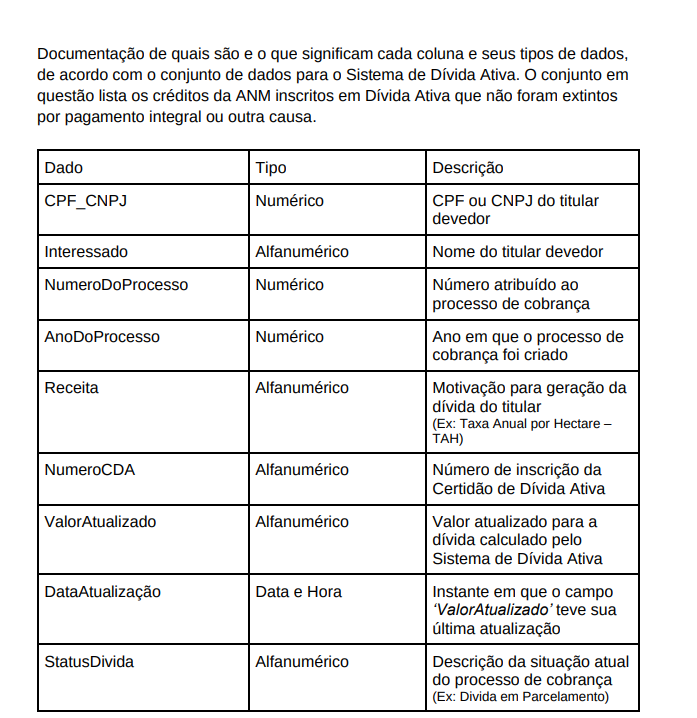

In [3]:
Image.open('Captura de tela de 2022-07-18 21-22-32.png')

etapa de extração

In [4]:
df = tabula.read_pdf('Dicionario+de+Dados+-+Procuradoria.pdf',pages='all')

In [5]:
df

[                Dado          Tipo                      Descrição
 0           CPF_CNPJ      Numérico         CPF ou CNPJ do titular
 1                NaN           NaN                        devedor
 2        Interessado  Alfanumérico        Nome do titular devedor
 3   NumeroDoProcesso      Numérico            Número atribuído ao
 4                NaN           NaN           processo de cobrança
 5      AnoDoProcesso      Numérico       Ano em que o processo de
 6                NaN           NaN            cobrança foi criado
 7            Receita  Alfanumérico      Motivação para geração da
 8                NaN           NaN              dívida do titular
 9                NaN           NaN  (Ex: Taxa Anual por Hectare –
 10               NaN           NaN                           TAH)
 11         NumeroCDA  Alfanumérico         Número de inscrição da
 12               NaN           NaN       Certidão de Dívida Ativa
 13   ValorAtualizado  Alfanumérico        Valor atualizado pa

In [6]:
df = df[0]

com essa função, o dado em formato tabular do PDF é carregado no python em uma estrutura de lista. Para cada tabela, uma lista. No caso do pdf aberto, contem apenas uma pagina
com uma tabela o que traz apenas uma lista com um elemento (contendo todo o conteudo da tabela no pdf)

Etapa de transformação


transforma primeiramente em Data frame

In [7]:
df

,Dado,Tipo,Descrição
0,CPF_CNPJ,Numérico,CPF ou CNPJ do titular
1,NaN,NaN,devedor
2,Interessado,Alfanumérico,Nome do titular devedor
3,NumeroDoProcesso,Numérico,Número atribuído ao
4,NaN,NaN,processo de cobrança
5,AnoDoProcesso,Numérico,Ano em que o processo de
6,NaN,NaN,cobrança foi criado
7,Receita,Alfanumérico,Motivação para geração da
8,NaN,NaN,dívida do titular
9,NaN,NaN,(Ex: Taxa Anual por Hectare –


In [8]:
#é possivel perceber que sempre quando ha duas linhas no mesmo retangulo do PDF, o programa pulou uma linha e acaba ficando como nulo varios campos como Dado e TIPO.
#preciso deixar toda a descrição no campo descrição, ao inves de pular uma linha para continuar o texto

#percorrendo todo o dataframe
Dado = []
Tipo = []
Descricao = []

for i in range(0, len(df)):
    if i+1 >= 22:
        break
    if pd.isna(df['Dado'][i]) == True: 
        pass #se for nulo o conteudo, não substitui nada
    elif pd.isna(df['Dado'][i+1]) == True: #quando o campo descrição ocupa mais de duas linhas
        descricao_auxiliar = df['Descrição'][i]
        for j in range(i+1,22):
            if pd.isna(df['Dado'][j]) == False: 
                break
            else:
                descricao_auxiliar = descricao_auxiliar + ' ' + df['Descrição'][j]
        Dado.append(df['Dado'][i])
        Tipo.append(df['Tipo'][i])
        Descricao.append(descricao_auxiliar)
    else:
         Dado.append(df['Dado'][i])
         Tipo.append(df['Tipo'][i])
         Descricao.append(df['Descrição'][i])   


In [9]:
df_final = pd.DataFrame({'Dado':Dado
                        ,'Tipo':Tipo
                        ,'Descricao':Descricao})

In [10]:
df_final

,Dado,Tipo,Descricao
0,CPF_CNPJ,Numérico,CPF ou CNPJ do titular devedor
1,Interessado,Alfanumérico,Nome do titular devedor
2,NumeroDoProcesso,Numérico,Número atribuído ao processo de cobrança
3,AnoDoProcesso,Numérico,Ano em que o processo de cobrança foi criado
4,Receita,Alfanumérico,Motivação para geração da dívida do titular (E...
5,NumeroCDA,Alfanumérico,Número de inscrição da Certidão de Dívida Ativa
6,ValorAtualizado,Alfanumérico,Valor atualizado para a dívida calculado pelo ...
7,DataAtualização,Data e Hora,Instante em que o campo ‘ValorAtualizado’ teve...
8,StatusDivida,Alfanumérico,Descrição da situação atual do processo de cob...


In [11]:
#teste para verificar a linha 4 com maior descrição
df_final[df_final.Dado == 'Receita']['Descricao'].values

array(['Motivação para geração da dívida do titular (Ex: Taxa Anual por Hectare – TAH)'],
      dtype=object)

etapa de carregamento

In [12]:
credenciais = service_account.Credentials.from_service_account_file(filename='GBQ.json'
                                                                    ,scopes =["https://www.googleapis.com/auth/cloud-platform"])

In [13]:
df_final.to_gbq(credentials=credenciais, 
                destination_table='curso_etl.etl_pdf', 
                if_exists='replace')